# Model Selection 

The objective of this notebook is to build a very first ent to end Machine Learning model to predict the probability of a patient being discharged on a particular day.

We'll use the dataset generated by the `dataset` job of the ETL folder. 

At this instance, the focus won't be on model performance but rather on understanding the value potential of the available data and the speedness of the solution.

In [1]:
%cd /Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital

/Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital


In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt   
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from thesis_lib.utils import * 
from thesis_lib.modelling.data import *
from thesis_lib.modelling.model import *
import warnings
warnings.filterwarnings('ignore')

/Users/josefinadallavia/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/josefinadallavia/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/josefinadallavia/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [20]:
data = Data().load('data/hospital_dataset')
variables = data.get_variables_dict()
data.get_stats()

Loading dataset:  hospital_train_data.parquet
Loading dataset:  hospital_val_data.parquet
Loading dataset:  hospital_test_data.parquet


dataset_type,train,val,test
n_observations,319150,33482,33309
relative_size,0.82694,0.0867542,0.0863059
n_cols,71,71,71
positives,42697,4555,4507
negatives,276453,28927,28802
positive_prop,0.133783,0.136043,0.135309
negative_prop,0.866217,0.863957,0.864691
min_date,2017-01-01,2018-11-11,2018-11-11
max_date,2018-11-10,2019-11-11,2019-11-11


In [21]:
variables['categorical_variables'].extend(['date_weekday','admission_weekday','date_month','admission_month'])

In [22]:
variables['categorical_variables']

['date',
 'images_requester_roles',
 'images_study_types',
 'labos_requester_roles',
 'sectors_last_sector',
 'sectors_names',
 'surgeries_actual',
 'surgeries_anesthesia_types',
 'surgeries_bact_positive',
 'surgeries_injury_condition',
 'surgeries_post_surgery_condition',
 'surgeries_scheduled',
 'surgeries_scheduled_done',
 'surgeries_services',
 'surgeries_types',
 'gender',
 'insurance_entity',
 'entity_group',
 'origin',
 'admission_sector',
 'isolation',
 'presumptive_dianogsis',
 'responsible_sector',
 'ARM_TEP',
 'CEC_TEP',
 'request_origin',
 'request',
 'request_diagnosis',
 'request_sector',
 'admission_date',
 'date_weekday',
 'admission_weekday',
 'date_month',
 'admission_month']

In [23]:
variables['numerical_variables']

['hosp_day_number',
 'images_count',
 'images_cumulative',
 'images_emergencies',
 'images_requester_roles_count',
 'images_requesters_count',
 'images_study_types_count',
 'labos_count',
 'labos_cumulative',
 'labos_emergencies',
 'labos_requester_roles_count',
 'labos_requesters_count',
 'labos_set_count',
 'labos_set_cumulative',
 'sectors_count',
 'sectors_last_stay',
 'surgeries_count',
 'surgeries_cumulative',
 'surgeries_post_surgery_duration',
 'surgeries_pre_surgery_duration',
 'surgeries_prep_duration',
 'surgeries_services_count',
 'surgeries_surgery_delay',
 'surgeries_surgery_duration',
 'surgeries_types_count',
 'emergency_service',
 'new_born_weight',
 'new_born_gestation_age',
 'PIM2TEP',
 'high_risk_TEP',
 'low_risk_TEP',
 'patient_age']

In [24]:
model_params = {'classifier': 'lgbm',
               'accepts_sparse': True,
                'categorical_features' : ['date_weekday','admission_weekday','date_month','admission_month']
                #'numerical_features' : variables['numerical_variables']
               }

In [25]:
lgbm_dateonly_features = Model(**model_params)
lgbm_dateonly_features.transform(data)

Fitting pipeline...
	 Preprocessing data
	 Encoding Categorical Features with OneHotEncoding
Transforming data...
	 Transforming categorical features
	 Preprocessing data
	 Transforming categorical features
	 Preprocessing data


### Baseline

In [26]:
%%time
lgbm_dateonly_features.fit_classifier()

Training classifier
[10]	training_set's auc: 0.618082	validation_set's auc: 0.611594
[20]	training_set's auc: 0.620919	validation_set's auc: 0.611646
[30]	training_set's auc: 0.623593	validation_set's auc: 0.612449
[40]	training_set's auc: 0.625018	validation_set's auc: 0.612795
[50]	training_set's auc: 0.626128	validation_set's auc: 0.612841
[60]	training_set's auc: 0.626859	validation_set's auc: 0.613099
[70]	training_set's auc: 0.62751	validation_set's auc: 0.61338
[80]	training_set's auc: 0.628039	validation_set's auc: 0.613451
[90]	training_set's auc: 0.628294	validation_set's auc: 0.613268
[100]	training_set's auc: 0.628606	validation_set's auc: 0.613113
CPU times: user 7.03 s, sys: 89.5 ms, total: 7.12 s
Wall time: 1.96 s


In [27]:
len(lgbm_dateonly_features.model_features)

33

In [28]:
lgbm_dateonly_features.get_performance_metrics()

training AUC ROC score:  0.6286063439277708
validation AUC ROC score:  0.6131131292795517
relative over-fitting:  0.0246469269645158


### Date + Extrafeatures

#### Baseline

In [10]:
model_params = {'classifier': 'lgbm',
               'accepts_sparse': True,
                'categorical_features' : variables['categorical_variables'],
                'numerical_features' : variables['numerical_variables']
               }

In [37]:
lgbm_date_features = Model(**model_params)
lgbm_date_features.transform(data)

Fitting pipeline...
	 Preprocessing data
	 Preprocessing data
	 Encoding Categorical Features with OneHotEncoding
Transforming data...
	 Transforming numerical features
	 Preprocessing data
	 Transforming categorical features
	 Preprocessing data
	 Transforming numerical features
	 Preprocessing data
	 Transforming categorical features
	 Preprocessing data


In [26]:
%%time
lgbm_date_features.fit_classifier()

Training classifier
[10]	training_set's auc: 0.860514	validation_set's auc: 0.854732
[20]	training_set's auc: 0.868238	validation_set's auc: 0.860738
[30]	training_set's auc: 0.872352	validation_set's auc: 0.863696
[40]	training_set's auc: 0.875371	validation_set's auc: 0.86593
[50]	training_set's auc: 0.877492	validation_set's auc: 0.867026
[60]	training_set's auc: 0.8791	validation_set's auc: 0.867855
[70]	training_set's auc: 0.880724	validation_set's auc: 0.868828
[80]	training_set's auc: 0.881994	validation_set's auc: 0.869261
[90]	training_set's auc: 0.882993	validation_set's auc: 0.869738
[100]	training_set's auc: 0.883953	validation_set's auc: 0.870056
CPU times: user 46 s, sys: 1.41 s, total: 47.4 s
Wall time: 16.9 s


In [27]:
len(lgbm_date_features.model_features)

28114

In [18]:
lgbm_date_features.get_performance_metrics()

training AUC ROC score:  0.8839530276609409
validation AUC ROC score:  0.8700563935174721
relative over-fitting:  0.01572100972405867


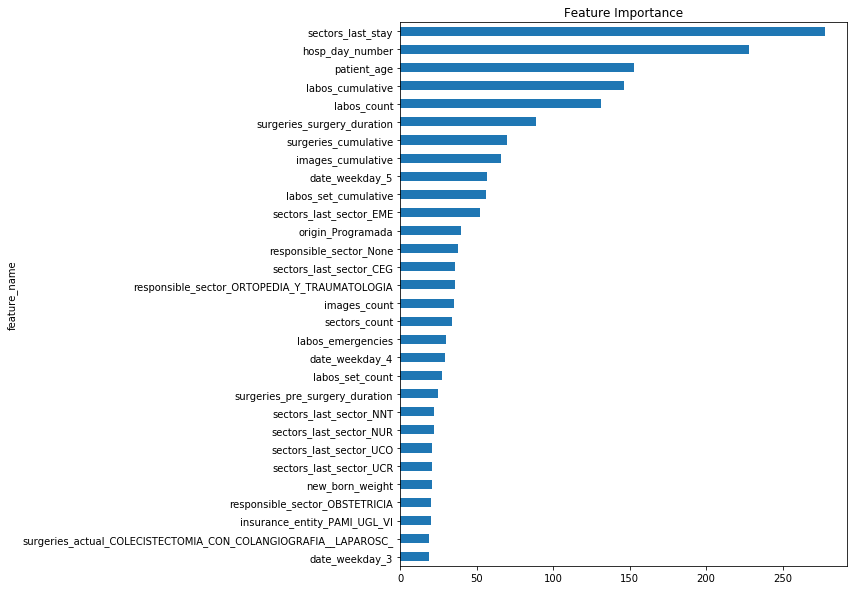

In [19]:
lgbm_date_features.plot_feature_importance()

In [31]:
lgbm_param_grid = {'max_depth': [3,7,10],
                  'learning_rate': [0.1,0.01,0.001,0.0001],
                  'num_iterations': [50,100,150,200,250]}

In [32]:
lgbm_date_features.optimize_hyperparams(params_dict=lgbm_param_grid,
                                         n_folds=3,n_iter=5,
                                         search_type='grid')

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

{'mean_fit_time': array([1.2580448 , 0.60016537, 0.29424469, 0.27443258, 0.18583743,
        0.24240406, 0.2255133 , 0.22574941, 0.24572396, 0.23204764,
        0.22521782, 0.24223399, 0.26435526, 0.25514698, 0.33993125,
        0.56015245, 0.43569279, 0.24545368, 0.28505015, 0.2685833 ,
        0.25265344, 0.30612397, 0.23082376, 0.25199389, 0.25856757,
        0.26304166, 0.30713487, 0.25804925, 0.21287044, 0.23083321,
        0.26789864, 0.25688831, 0.29191128, 0.25986973, 0.23366268,
        0.22994375, 0.23471196, 0.21968953, 0.22942241, 0.21228107,
        0.22520359, 0.22084761, 0.22829111, 0.24002528, 0.24013702,
        0.23859413, 0.22841001, 0.2361722 , 0.2205437 , 0.26957997,
        0.3498168 , 0.25588226, 0.29727817, 0.30975699, 0.25784771,
        0.24995716, 0.25337696, 0.2434539 , 0.27311023, 0.22468464]),
 'std_fit_time': array([0.1010461 , 0.51189238, 0.004585  , 0.01916742, 0.0146934 ,
        0.00418058, 0.03609736, 0.00852796, 0.03104814, 0.00653695,
        0.017

In [18]:
exp_results = lgbm_date_features.get_model_selection_results()

In [19]:
exp_results.to_csv('experiments/lgb_date_features_grid_search_results.csv')

In [20]:
best_params = lgbm_date_features.model_selection.best_params_
best_params

{'learning_rate': 0.1, 'max_depth': 7, 'num_iterations': 200}

In [38]:
%%time
lgbm_date_features.fit_classifier(**{'learning_rate': 0.1, 'max_depth': 7, 'num_iterations': 200})

Training classifier


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100


[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s


building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.7s


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100


[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.1s


building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.5s


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.9s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.3s


building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100


[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.9s


building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100


[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    3.3s


building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100


[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    3.8s


building tree 85 of 100
building tree 86 of 100
building tree 87 of 100building tree 88 of 100

building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:    4.4s


CPU times: user 8.59 s, sys: 470 ms, total: 9.06 s
Wall time: 4.95 s


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    4.7s finished


In [15]:
lgbm_date_features.get_performance_metrics()

training AUC ROC score:  0.8912276881944082
validation AUC ROC score:  0.8717363899140184
relative over-fitting:  0.02187016689290529


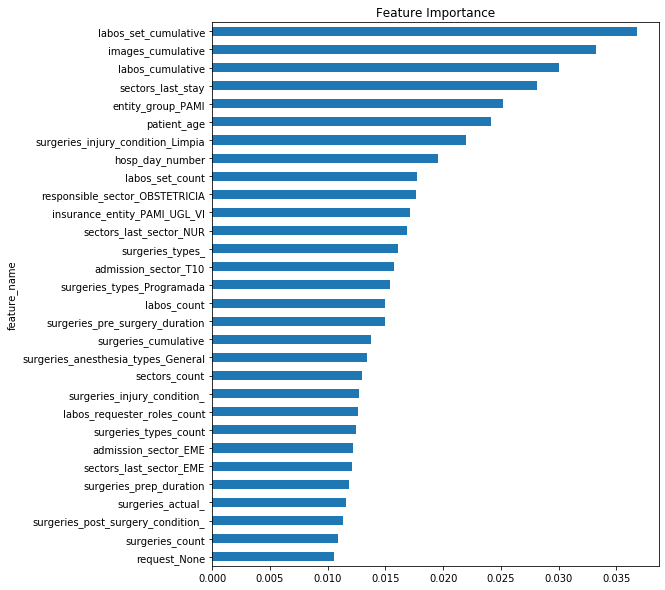

In [41]:
lgbm_date_features.plot_feature_importance(30)

In [30]:
model_params = {'classifier': 'random_forest',
               'accepts_sparse': True,
                'categorical_features' : variables['categorical_variables'],
                'numerical_features' : variables['numerical_variables']
               }

In [31]:
rf_date_features = Model(**model_params)
rf_date_features.transform(data)

Fitting pipeline...
	 Preprocessing data
	 Preprocessing data
	 Encoding Categorical Features with OneHotEncoding
Transforming data...
	 Transforming numerical features
	 Preprocessing data
	 Transforming categorical features
	 Preprocessing data
	 Transforming numerical features
	 Preprocessing data
	 Transforming categorical features
	 Preprocessing data


In [32]:
%%time
rf_date_features.fit_classifier()

Training classifier


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.3s


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.7s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.0s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.5s


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    2.1s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s


building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.4s


building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100


[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    4.3s


building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    5.0s


building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100


[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    5.8s


building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:    6.7s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
CPU times: user 13 s, sys: 526 ms, total: 13.6 s
Wall time: 7.34 s


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.0s finished


In [13]:
rf_date_features.get_performance_metrics()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks  

training AUC ROC score:  0.7854417825973606
validation AUC ROC score:  0.779793535314699
relative over-fitting:  0.007191172417621582


In [14]:
rf_param_grid = {'max_depth': [7,10,15],
                  'max_features': ['sqrt','log2'],
                  'n_estimators': [100,150,200,300]}

In [15]:
rf_date_features.optimize_hyperparams(params_dict=rf_param_grid,n_folds=3,search_type='grid')

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   23.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   48.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  3.3min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  4.1min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  9.2min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 11.0min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 16.4min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 20.9min
[Parallel(n_jobs=2)]: Done  72 out of  72 | elapsed: 22.6min finished


{'mean_fit_time': array([ 18.35230319,  22.49105167,  29.02735027,  43.90030471,
          7.11494263,  10.91593575,  14.44926278,  21.7092034 ,
         22.87233202,  34.39189704,  44.168365  ,  68.22285962,
         11.02731975,  15.57228772,  20.95006967,  30.31606301,
         38.39459443,  58.00918023,  76.36053308, 119.20530462,
         16.43630679,  24.71530485,  33.07221874,  48.75604169]),
 'std_fit_time': array([2.38424045, 0.1955741 , 0.4237287 , 0.36712506, 0.11580417,
        0.12332684, 0.09702811, 0.47329554, 0.36045461, 1.26346451,
        0.63433614, 2.33111499, 0.59631469, 0.4338153 , 0.05047927,
        0.50838067, 1.053346  , 1.0882689 , 0.94952359, 2.02807219,
        0.18965679, 0.33556775, 0.5468608 , 5.22387405]),
 'mean_score_time': array([1.47419294, 1.84619403, 2.67519212, 3.59847029, 1.31455763,
        1.88671271, 2.46947527, 3.97129337, 1.39374916, 2.21484319,
        2.84794569, 4.41730976, 1.41149306, 2.16817967, 2.94690688,
        4.21879832, 1.688723

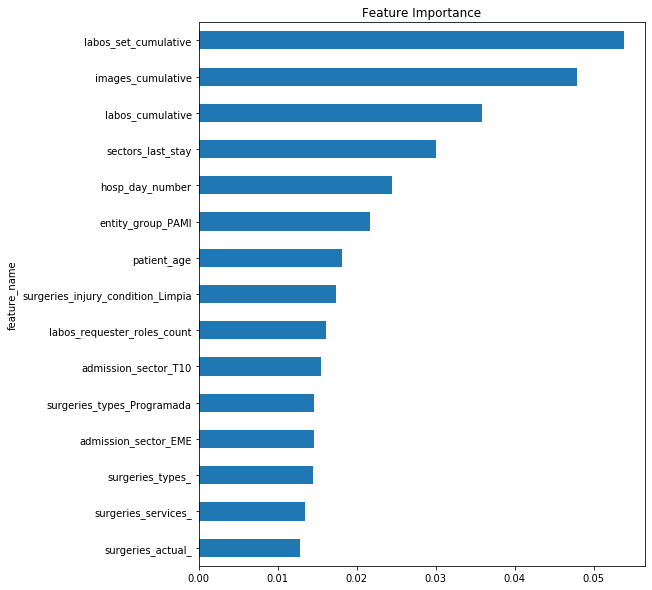

In [34]:
rf_date_features.plot_feature_importance(15)

In [16]:
exp_results = rf_date_features.get_model_selection_results()
exp_results.to_csv('experiments/rf_date_features_grid_search_results.csv')

In [17]:
best_params = rf_date_features.model_selection.best_params_
best_params

{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}

In [18]:
%%time
rf_date_features.fit_classifier(**best_params)

Training classifier


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100



[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100


[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.7s


building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.8s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    2.5s


building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    3.9s


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100


[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    5.1s


building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    6.6s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.9s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100


[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    9.8s


building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100


[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   11.5s


building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   13.5s


building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100


[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   15.6s


building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
CPU times: user 31.6 s, sys: 791 ms, total: 32.4 s
Wall time: 17.1 s


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   16.5s finished


In [19]:
rf_date_features.get_performance_metrics()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks  

training AUC ROC score:  0.810422630190757
validation AUC ROC score:  0.7948731385872088
relative over-fitting:  0.019186892152663858
